In [1]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

# reading example file

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'

In [3]:
catalog = fio.read(catalog_path)

In [4]:
catalog_cluster = catalog[catalog['LOC'] == 1]

In [5]:
# catalog_field = catalog[catalog['LOC'] == 2]

In [6]:
catalog_field = catalog[catalog['LOC'] == 0]

# creating canvas

In [7]:
xx = catalog['X'] - 2500.
yy = catalog['Y'] - 2500.
canvas_size = 5000.

In [8]:
pixel_scale = 0.264
sky_level = 1.e2                # ADU / arcsec^2
psf_fwhm = 0.9

In [9]:
psf = galsim.Gaussian(fwhm=0.9)

In [10]:
gal_image = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)

In [11]:
band = "g"

In [12]:
band.upper()

'G'

In [13]:
def draw_image(canvas, catalog, band='g'):
    for i in np.arange(len(catalog)):
        bdf_pars = np.zeros(7)
        bdf_pars[2] = catalog["G1"][i]
        bdf_pars[3] = catalog["G2"][i]
        bdf_pars[4] = catalog["TSIZE"][i]
        bdf_pars[5] = catalog["FRACDEV"][i]
        bdf_pars[6] = catalog["FLUX_" +band.upper()][i]
        galmaker = ngmix.gmix.GMixBDF(bdf_pars)
        gs_profile = galmaker.make_galsim_object()
        final_gal = galsim.Convolve([psf, gs_profile])
        stamp_size = final_gal.getGoodImageSize(pixel_scale)

        xx = catalog['X'][i] - 2500.
        yy = catalog['Y'][i] - 2500.



        x_cen = np.floor(xx)
        y_cen = np.floor(yy)

        offset = (xx - x_cen, yy - y_cen)
        b = galsim.BoundsI(x_cen - stamp_size / 2+1  , x_cen + stamp_size/ 2,
                           y_cen - stamp_size / 2 +1,  y_cen + stamp_size / 2)
        sub_gal_image = canvas[b]
        final_gal.drawImage(sub_gal_image, offset=offset, add_to_image=True)
#         print(canvas[b].array.min(), canvas[b].array.mean())
    return canvas


In [14]:
for i, band in enumerate(["g", 'r', 'i', 'z']):
    ud = galsim.UniformDeviate(31415926 + i)
    noise = galsim.GaussianNoise(ud, sigma=0.1)
    print(band)
    
    canvas = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)
    canvas.addNoise(noise)
    canvas = draw_image(canvas, catalog_cluster, band=band)
    fio.write("image_" + band + ".fits", canvas.array)

g
r
i
z


In [15]:
ud = galsim.UniformDeviate(31415926)
noise = galsim.GaussianNoise(ud, sigma=0.1)

In [16]:
canvas = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)

In [17]:
canvas.addNoise(noise)
canvas = draw_image(canvas, catalog_cluster, band="g")


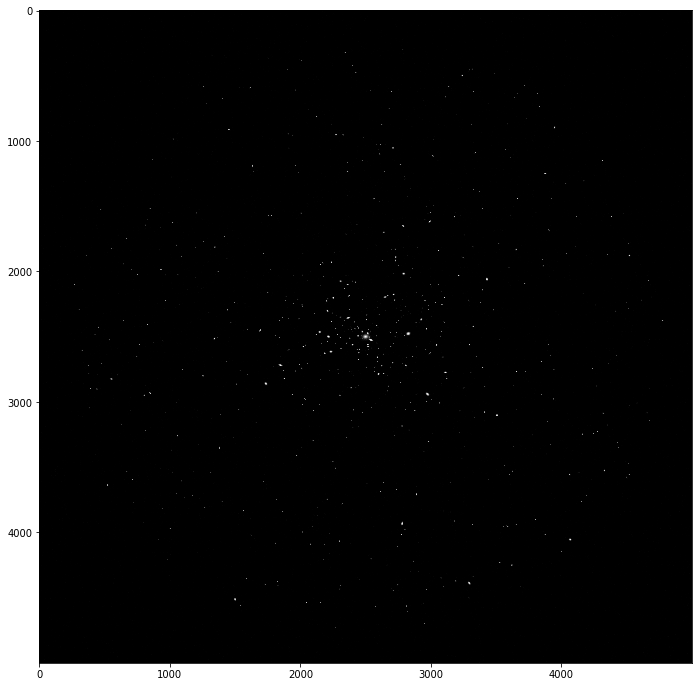

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = canvas.array
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)
# ax.imshow(canvas.array)

fig.savefig('cluster_only_test_G.png', dpi=300)

In [19]:
gal_image = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)
for i in np.arange(1000):
    bdf_pars = np.zeros(7)
    bdf_pars[2] = catalog["G1"][i]
    bdf_pars[3] = catalog["G2"][i]
    bdf_pars[4] = catalog["TSIZE"][i]
    bdf_pars[5] = catalog["FRACDEV"][i]
    bdf_pars[6] = catalog["FLUX_G"][i]
    galmaker = ngmix.gmix.GMixBDF(bdf_pars)
    gs_profile = galmaker.make_galsim_object()
    final_gal = galsim.Convolve([psf, gs_profile])
    stamp_size = final_gal.getGoodImageSize(pixel_scale)
    
    xx = catalog['X'][i] - 2500.
    yy = catalog['Y'][i] - 2500.
    
    
    
    x_cen = np.floor(xx)
    y_cen = np.floor(yy)

    offset = (xx - x_cen, yy - y_cen)
    b = galsim.BoundsI(x_cen - stamp_size / 2+1  , x_cen + stamp_size/ 2,
                       y_cen - stamp_size / 2 +1,  y_cen + stamp_size / 2)
    sub_gal_image = gal_image[b]
    final_gal.drawImage(sub_gal_image, offset=offset, add_to_image=True)
    
# sky_level_pixel = sky_level * pixel_scale**2
# noise = galsim.PoissonNoise(ud, sky_level=sky_level_pixel)
# gal_image.addNoiseSNR(noise, 100)    

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


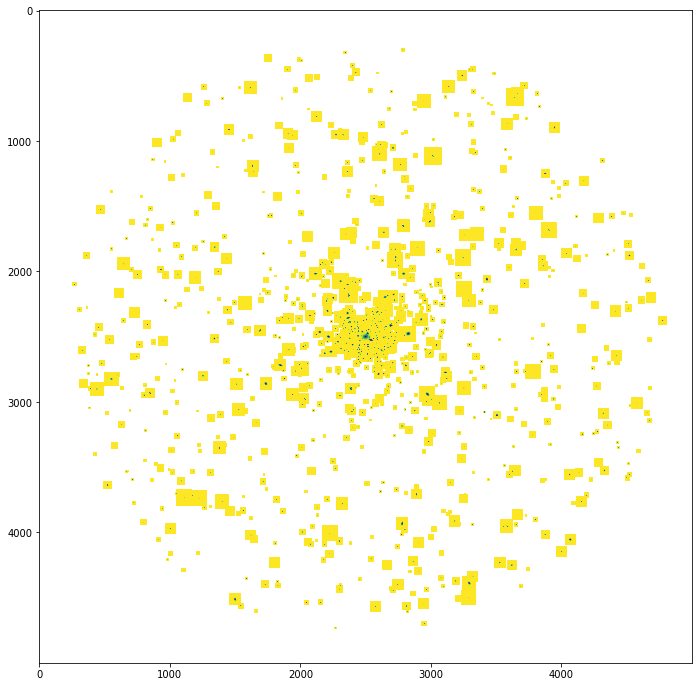

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(np.arcsinh(gal_image.array) / gal_image.array)
fig.savefig('postate_stamp_outline.png', dpi=300)

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


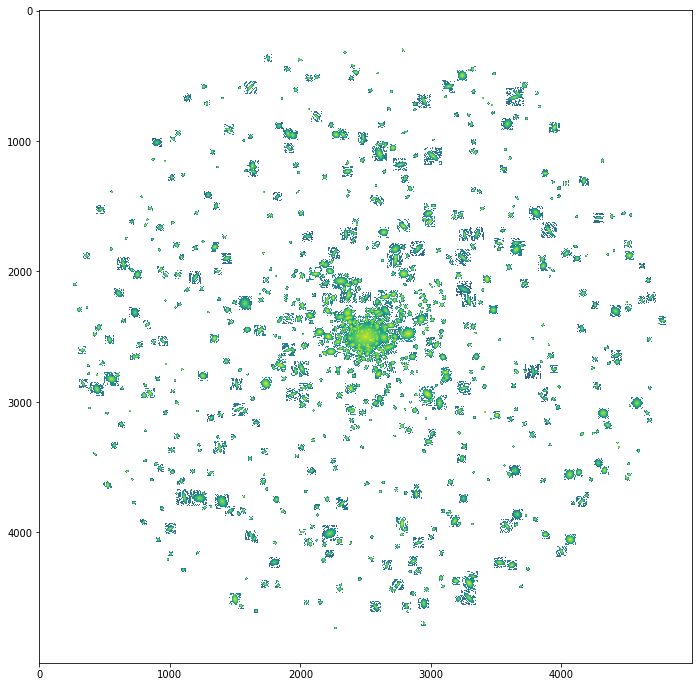

In [21]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(np.log(gal_image.array))

In [22]:
offset

(0.99050200199963, 0.6722631373431796)

In [23]:
b = galsim.BoundsI(2500 - stamp_size / 2+1  , 2500 + stamp_size/ 2,
                   2500 - stamp_size / 2 +1, 2500 + stamp_size / 2)
sub_gal_image = gal_image[b]
# sub_psf_image = psf_image[b]

In [24]:
bdf_pars = np.zeros(7)
bdf_pars[2] = catalog["G1"][i]
bdf_pars[3] = catalog["G2"][i]
bdf_pars[4] = catalog["TSIZE"][i]
bdf_pars[5] = catalog["FRACDEV"][i]
bdf_pars[6] = catalog["FLUX_G"][i]
galmaker = ngmix.gmix.GMixBDF(bdf_pars)
gs_profile = galmaker.make_galsim_object()

In [25]:
final_gal = galsim.Convolve([psf, gs_profile])

In [26]:
final_gal.getGoodImageSize(0.264)

50

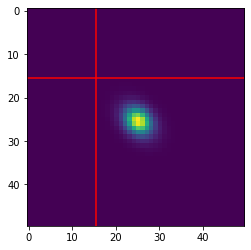

In [27]:
final_gal.drawImage(sub_gal_image, offset=(0.5, 0.9))
plt.imshow(sub_gal_image.array)
plt.axvline(15.5, color='red')
plt.axhline(15.5, color='red')

In [28]:
sub_gal_image.array.shape

(50, 50)

In [29]:
sub_gal_image

galsim.Image(bounds=galsim.BoundsI(xmin=2476, xmax=2525, ymin=2476, ymax=2525), array=
array([[ 4.3972673e-07,  3.1719276e-07,  3.1522569e-07, ...,
        -4.1277997e-07, -3.1179377e-07, -2.5697989e-07],
       [ 3.9120269e-07,  4.5803250e-07,  6.5843699e-07, ...,
        -5.3468005e-07, -4.2418887e-07, -3.4896902e-07],
       [ 4.3010934e-07,  6.9796272e-07,  8.9049649e-07, ...,
        -6.3703436e-07, -5.1464338e-07, -4.2337342e-07],
       ...,
       [-4.0883569e-07, -5.1597840e-07, -5.9971728e-07, ...,
         3.7453074e-07,  6.5545959e-07,  8.2309037e-07],
       [-3.6231432e-07, -4.5068424e-07, -5.4404660e-07, ...,
         6.1398339e-07,  8.4857652e-07,  8.1601826e-07],
       [-3.1949233e-07, -3.8973894e-07, -4.8482173e-07, ...,
         8.2176194e-07,  8.3722949e-07,  6.2698962e-07]], dtype=float32), wcs=galsim.PixelScale(0.264))

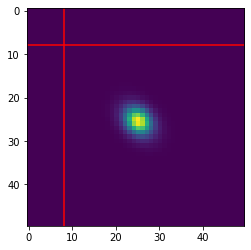

In [30]:
plt.imshow(sub_gal_image.array)
plt.axvline(8, color='red')
plt.axhline(8, color='red')

In [31]:
# Great08 randomized the locations of the two galaxies in each pair,
# but for simplicity, we just do them in sequential postage stamps.
if first_in_pair:
    # Use a random orientation:
    beta = ud() * 2. * math.pi * galsim.radians

    # Determine the ellipticity to use for this galaxy.
    ellip = 1
    while (ellip > gal_ellip_max):
        # Don't do `ellip = math.fabs(gd())`
        # Python basically implements this as a macro, so gd() is called twice!
        val = gd()
        ellip = math.fabs(val)

    # Make a new copy of the galaxy with an applied e1/e2-type distortion
    # by specifying the ellipticity and a real-space position angle
    ellip_gal = gal.shear(e=ellip, beta=beta)

    first_in_pair = False
else:
    # Use the previous ellip_gal profile and rotate it by 90 degrees
    ellip_gal = ellip_gal.rotate(90 * galsim.degrees)

    first_in_pair = True

# Apply the gravitational reduced shear by specifying g1/g2
this_gal = ellip_gal.shear(g1=gal_g1, g2=gal_g2)

# Apply a random shift_radius:
rsq = 2 * shift_radius_sq
while (rsq > shift_radius_sq):
    dx = (2*ud()-1) * shift_radius
    dy = (2*ud()-1) * shift_radius
    rsq = dx**2 + dy**2

this_gal = this_gal.shift(dx,dy)
# Note that the shifted psf that we create here is purely for the purpose of being able
# to draw a separate, shifted psf image.  We do not use it when convolving the galaxy
# with the psf.
this_psf = psf.shift(dx,dy)

# Make the final image, convolving with the (unshifted) psf
final_gal = galsim.Convolve([psf,this_gal])

NameError: name 'first_in_pair' is not defined

In [ ]:
final_gal.drawImage(sub_gal_image)


In [ ]:
plt.imshow(sub_gal_image.array)

In [ ]:
reload(gen)

In [ ]:
ms = gen.MockupSurvey()

In [ ]:
ms.draw()

In [ ]:
import ngmix

In [ ]:
ngmix.gmix.GMixBDF()